In [1]:
from __future__ import annotations

import math
import random
import torch.nn as nn
import torch.optim as optim
import torch.autograd
import torch.nn.functional as F
import gymnasium as gym

from collections import defaultdict, namedtuple, deque
from itertools import count

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
#Create environment
env = gym.make("CartPole-v1")

In [50]:
env.close()
env = gym.make("CartPole-v1", render_mode="human")

In [3]:
#Create the Replay Buffer class
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
class CartPoleAgent:
    def __init__(
        self,
        model,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an untrained Deep Q-Network, a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
            q_value_model: The DQN which outputs a Q-value for each of the two possible actions
        """

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.model = model

        self.training_error = []

    def get_action(self, obs) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(torch.argmax(self.model(obs)))


    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [5]:
def get_action(state, model, epsilon) -> int:
    """
    Returns the best action with probability (1 - epsilon)
    otherwise a random action with probability epsilon to ensure exploration.
    """
    # with probability epsilon return a random action to explore the environment
    if np.random.random() < epsilon:
        return env.action_space.sample()
    # with probability (1 - epsilon) act greedily (exploit)
    else:
        return int(torch.argmax(model(state)))

In [40]:
#Create the model
class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4,128)
        self.fc2 = nn.Linear(128,128)
        self.fc3 = nn.Linear(128,2)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [41]:
#Instantiate the models
model = DQN()
model.to(device)
target_model = DQN()
target_model.to(device)
for param in target_model.parameters():
    param.requires_grad = False

In [42]:
state_size = env.observation_space.shape[0]
num_episodes = 300
batch_size = 128
buffer_size = 50_000
replay_buffer = ReplayMemory(buffer_size)

In [ ]:
# foobar = ReplayMemory(2)
# print(Transition([0.1,0.2,0.05,0.5],1,[0.2,0.3,0.06,0.7],1))
# foobar.push([0.1,0.2,0.05,0.5],1,[0.2,0.3,0.06,0.7],1)
# foobar.push([0.1,0.2,0.05,0.5],1,[0.2,0.3,0.06,0.7],1)
# print(foobar.sample(2))
# print(foobar.__len__())
# foobar.push(2,3,4,5)
# print(foobar.__len__())

In [20]:
learning_rate = 0.0001
tau = 0.005
initial_epsilon = 1.0
epsilon_decay = initial_epsilon / (num_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.01
discount_factor = 0.99

In [43]:
agent = CartPoleAgent(
    model=model,
    learning_rate=learning_rate,
    initial_epsilon=initial_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount_factor
)

In [48]:
agent = CartPoleAgent(
    model=model,
    learning_rate=learning_rate,
    initial_epsilon=0,
    epsilon_decay=epsilon_decay,
    final_epsilon=0,
    discount_factor=discount_factor
)

In [44]:
criterion = torch.nn.HuberLoss(delta=1)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate)

In [12]:
print(replay_buffer.__len__())

0


In [285]:
env.close()
env = gym.make("CartPole-v1", render_mode="human")

In [54]:
import os
cwd = os.getcwd()
print(cwd)

c:\Users\Maruf\Documents\Programming\RL


In [58]:
# Define the path where you want to save the checkpoint
checkpoint_path = "dqn_cartpole_params.ckpt"

# Save the model state
additional_info = {
    'model_state_dict': model.state_dict(),
    'target_state_dict': target_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}

torch.save(additional_info, checkpoint_path)

In [56]:
checkpoint = torch.load(checkpoint_path)
print(checkpoint['model_state_dict'])

OrderedDict([('fc1.weight', tensor([[-4.1690e-01,  1.2828e-01, -5.3537e-01,  1.8661e-01],
        [ 2.2383e-01, -1.8354e-01,  3.0840e-01,  1.8326e-01],
        [ 1.0515e-02,  2.9164e-01,  2.0266e-02, -4.8822e-01],
        [ 1.3669e-01, -1.6774e-01, -2.0988e-01, -3.3313e-01],
        [-3.0039e-01, -2.8769e-01, -9.7468e-01, -2.5066e-01],
        [ 4.6681e-01, -3.3675e-01, -9.0262e-02, -1.8620e-01],
        [ 6.4833e-01,  6.1869e-02, -8.2932e-03, -7.1837e-02],
        [-4.5104e-01,  1.2695e-01,  2.5816e-01,  1.6507e-01],
        [ 2.3667e-01,  5.9132e-01,  2.4720e-01, -2.6330e-01],
        [-3.2625e-01, -1.7974e-01, -7.3368e-01, -1.8830e-01],
        [-2.3687e-01, -2.1682e-01, -7.2480e-01, -2.8373e-02],
        [ 2.2870e-01,  5.1391e-01,  2.3083e-01, -3.9481e-01],
        [ 2.7724e-01, -1.9558e-01,  3.5915e-02,  1.2872e-01],
        [ 1.1412e-01,  2.1128e-01,  3.7553e-01,  2.1572e-01],
        [-3.2900e-01,  1.7847e-01,  7.7313e-01, -2.6875e-01],
        [-7.6275e-02, -3.0969e-01, -1.3062

In [53]:
#Create the training loop
model.train()
prev_iterations = 0
iterations = 0
returns_list = []

for j in range(num_episodes):
    done = False
    current_state, _ = env.reset()
    current_state = torch.tensor(current_state, device=device).unsqueeze(0)
    
    while not done:
        effective_batch_size = min(batch_size, replay_buffer.__len__()+1)
        
        action = get_action(current_state, model, epsilon=agent.epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(next_state, device=device).unsqueeze(0)

        replay_buffer.push(current_state, action, next_state, reward)
        
        transitions = replay_buffer.sample(batch_size=effective_batch_size)
        batch = Transition(*zip(*transitions))

        batch_states = torch.cat(batch.state)
        batch_rewards = torch.tensor(batch.reward, device=device)
        batch_actions = torch.tensor(batch.action, device=device)
        batch_next_states = torch.cat([s for s in batch.next_state if s is not None])

        with torch.no_grad():
            mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
            best_next_q_values = torch.zeros(effective_batch_size, device=device)
            best_next_q_values[mask] = torch.max(target_model(batch_next_states), 1).values
            target_q_values = batch_rewards + discount_factor*best_next_q_values


        predicted_q_values = model(batch_states)
        predicted_q_values = predicted_q_values[torch.arange(effective_batch_size), batch_actions]

        
        loss = criterion(predicted_q_values, target_q_values)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        current_state = next_state
        done = terminated or truncated
        iterations += 1
        target_model_state_dict = target_model.state_dict()
        model_state_dict = model.state_dict()
        for key in model_state_dict:
            target_model_state_dict[key] = model_state_dict[key]*tau + target_model_state_dict[key]*(1-tau)
        target_model.load_state_dict(target_model_state_dict)
    episode_length = iterations-prev_iterations
    prev_iterations = iterations
    
    returns_list.append(episode_length)
    agent.decay_epsilon() 
    print(f"Ep: {j+1} Return: {episode_length} Eps: {agent.epsilon:.2f}")





Ep: 1 Return: 500 Eps: 0.00


KeyboardInterrupt: 

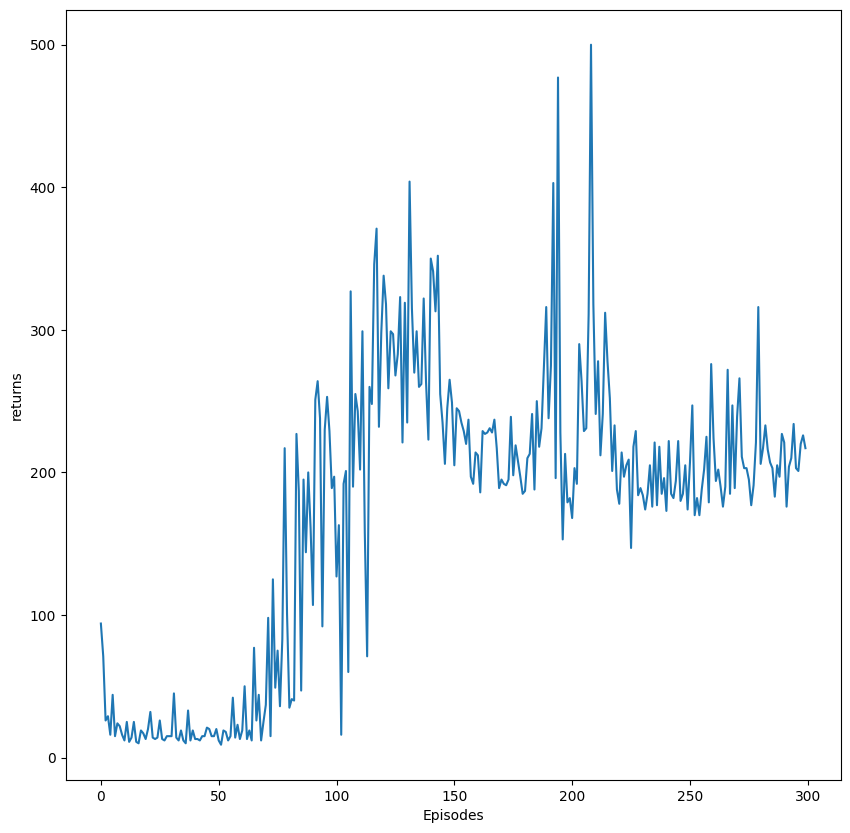

In [46]:
plt.figure(figsize=(10,10))
plt.plot(range(len(returns_list)), returns_list)
plt.xlabel('Episodes')
plt.ylabel('returns')
plt.show()

In [47]:
print(max(returns_list))
print(sum(returns_list[150:])/150)

500
218.59333333333333
